In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn
from torchsummary import summary

import importlib

import matplotlib.pyplot as plt
from IPython import display

sys.path.insert(0, "../src/")
import data
import model

np.random.seed(11)

In [2]:
def plot_X(X, y, figsize=(16,6), n_row=2, n_col=3, n_show=4, file=None):
    
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        if X.dim() == 4:
            axs[i].plot(X[i, :, 0, :].T)
        else:
            axs[i].plot(X[i].T)
        if y is not None:
            axs[i].plot(y[i], "r")
        
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

In [3]:
def live_plot_nb(y_out, y_trg, step, n_steps, loss, lr, figsize=(16,6), n_row=1, n_col=2, n_show=2, show_loss=True, log=False, file=None):
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        axs[i].plot(y_trg[i])
        axs[i].plot(y_out[i])

    if show_loss:
        axs[i+1].plot(loss)
        axs[i+2].plot(lrs)
    
    if log:
        axs[i+1].set_xscale("log")
        axs[i+1].set_yscale("log")
        axs[i+2].set_xscale("log")
        axs[i+2].set_yscale("log")
    
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

# Define data generation parameters

In [4]:
data_pars = dict(
                 # General parameters
                 td = 256, # Number of points
                 Fs = 12800, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 1, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                 iso_p = [0.8, 0.2],
                 iso_p_peakwise = True,
                 iso_int = [0.5, 1.], # Intensity
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 15, # Maximum number of peaks
                 shift_range = [2000., 10000.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-dependent parameters
                 mas_g_range = [[1e10, 1e11], [1e10, 5e11]], # MAS-dependent Gaussian broadening range
                 mas_l_range = [[1e7, 1e8], [1e7, 5e8]], # MAS-dependent Lorentzian broadening range
                 mas_s_range = [[-1e7, 1e7], [-1e7, 1e7]], # MAS-dependent shift range
                 mas_p = [0.8, 0.2],

                 # Second-order MAS-dependent parameters
                 mas_w2 = False,
                 mas_w2_p = 1.,
                 mas2_g_range = [[1e13, 1e15], [1e15, 1e16]], # MAS-dependent Gaussian broadening range
                 mas2_l_range = [[1e10, 1e12], [1e12, 1e13]], # MAS-dependent Lorentzian broadening range
                 mas2_s_range = [[-2e11, 2e11], [-2e11, 2e11]], # MAS-dependent shift range
                 mas2_p = [0.8, 0.2],

                 mas_phase = 0.1, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 9, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = False,
                 encode_w = True, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 iso_norm = 256., # Normalization factor for peaks
                 brd_norm = 64., # Normalization factor for MAS spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

train_pars = dict(batch_size = 64,
                  num_workers = 8,
                  checkpoint = 10,
                  n_eval = 5,
                 )

model_pars = dict(n_models = 5,
                  input_dim = 2,
                  hidden_dim = 64,
                  kernel_size = [[5, 5, 5, 5, 5, 5], [7, 7, 7, 7, 7, 7], [9, 9, 9, 9, 9, 9], [11, 11, 11, 11, 11, 11], [13, 13, 13, 13, 13, 13]],
                  num_layers = 6,
                  final_kernel_size = 1,
                  batch_input = 4,
                  bias = True,
                  final_bias = True,
                  independent = True,
                  return_all_layers = True,
                  final_act = "linear",
                  noise = 2.e-4,
                 )

fig_dir = "../figures/lstm_sanity_check/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [9]:
dataset = data.PIPDataset(**data_pars)

In [13]:
c0 = np.array([0., 1., 1.])
dc = np.array([0.,-1., 0.])

seed = 11

np.random.seed(seed)

brd_specs, specs, iso = dataset.__getitem__(0)



for i, s in enumerate(brd_specs[:, 0]):
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(dataset.f, s, c=c0 + (i / (brd_specs.shape[0]-1)) * dc)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    fig.tight_layout()
    plt.savefig(f"{fig_dir}mas_spec_{i}.png", dpi=300, transparent=True)
    plt.close()

In [14]:
batch = 6
x_offset=100
y_offset=0.01


for i, s in enumerate(brd_specs[:, 0]):
    if i + batch >= brd_specs.shape[0]:
        break
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(1,1,1)
    for j in range(batch):
        ax.plot(dataset.f+j*x_offset, brd_specs[i+j, 0]+j*y_offset, c=c0 + ((i+j) / (brd_specs.shape[0]-1)) * dc, zorder=-j)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    fig.tight_layout()
    plt.savefig(f"{fig_dir}batch_mas_spec_{i}.png", dpi=300, transparent=True)
    plt.close()

In [19]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

ax.plot(dataset.f+j*x_offset, iso[0], "k")

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

fig.tight_layout()
plt.savefig(f"{fig_dir}pip_spec.png", dpi=300, transparent=True)
plt.close()

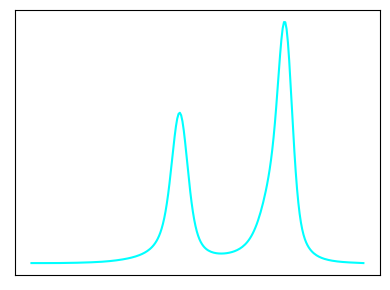

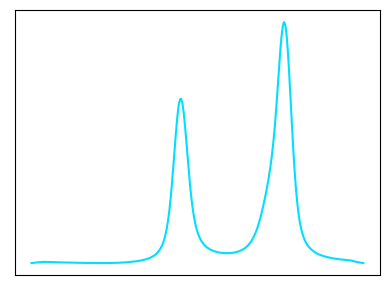

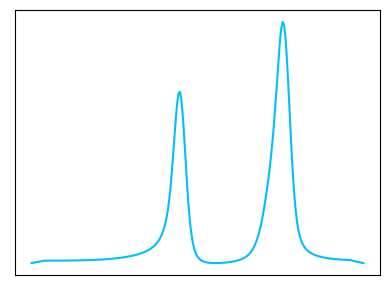

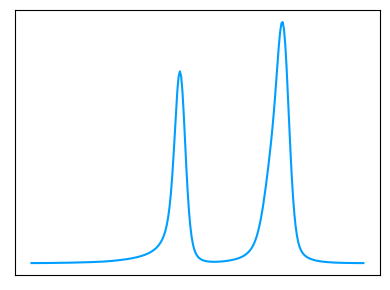

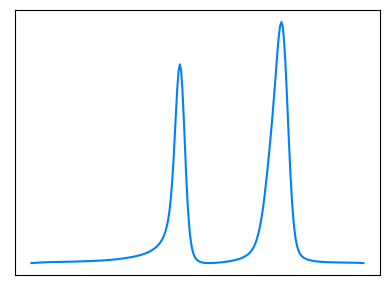

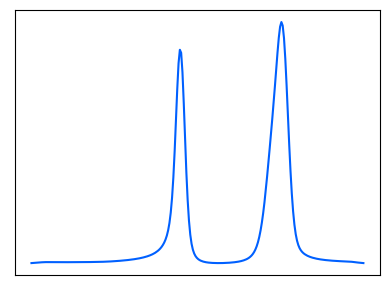

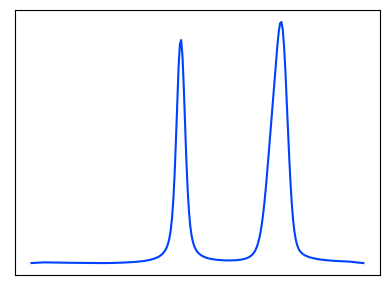

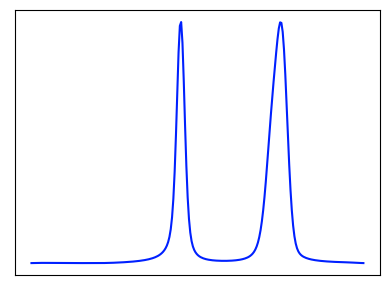

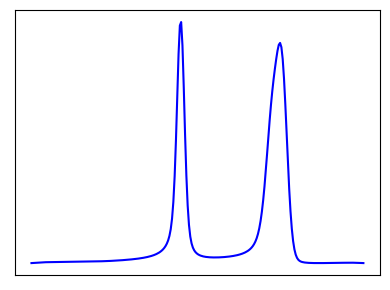

In [13]:
c0 = np.array([0., 1., 1.])
dc = np.array([0.,-1., 0.])

seed = 11

np.random.seed(seed)

brd_specs, specs, iso = dataset.__getitem__(0)

batch=6
i0=0

for i, spec in enumerate(brd_specs[:, 0]):
    if i 
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(dataset.f, brd_specs[i, 0], c=c0 + (i / (brd_specs.shape[0]-1)) * dc)
    
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    plt.close()

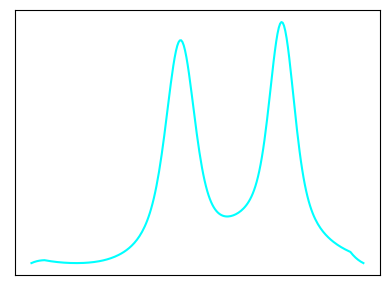

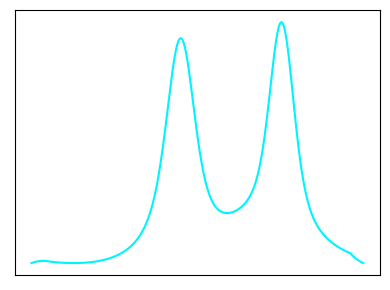

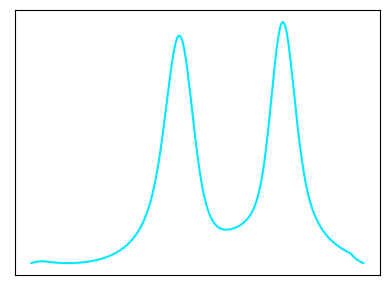

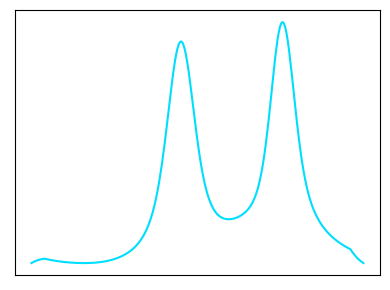

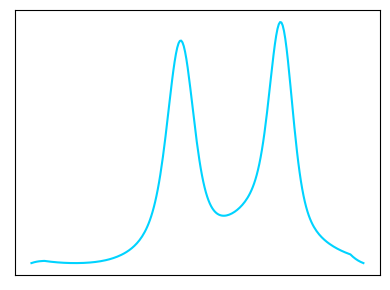

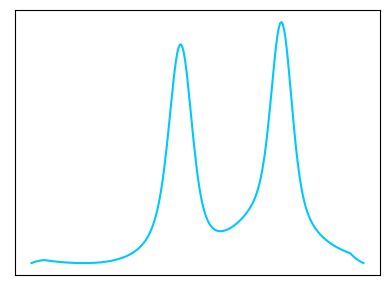

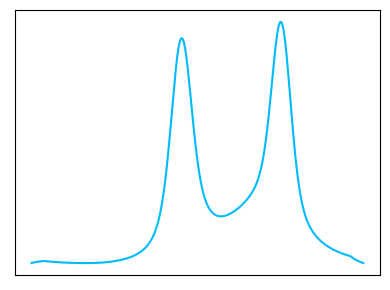

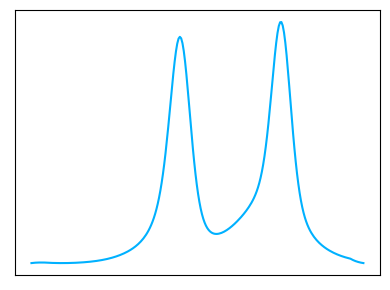

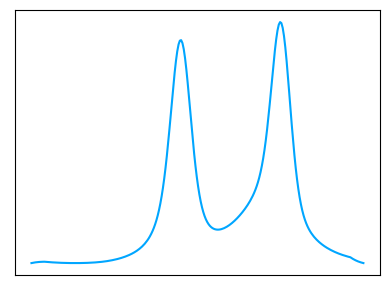

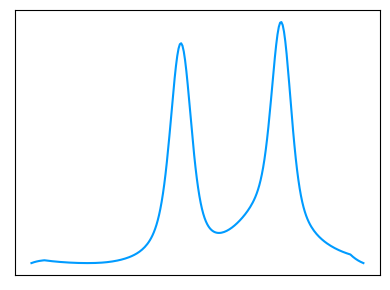

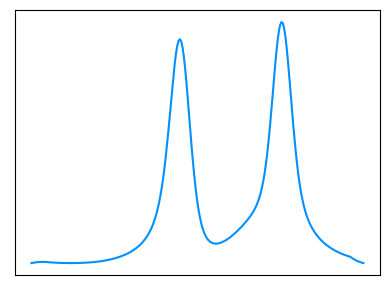

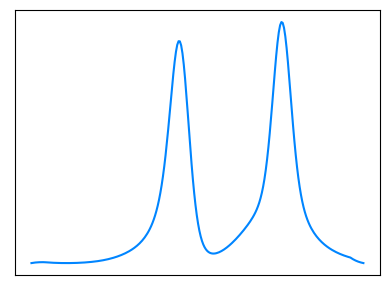

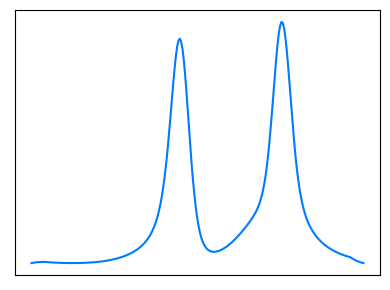

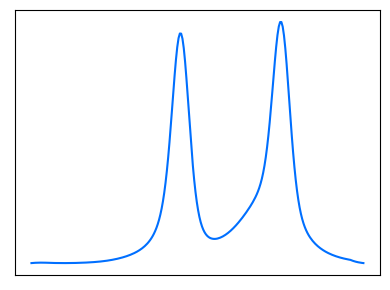

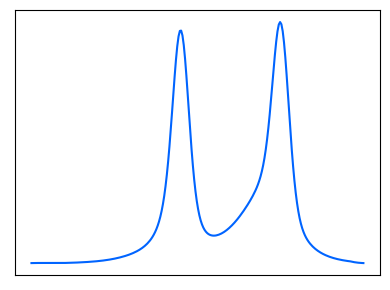

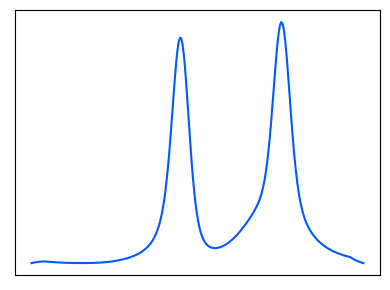

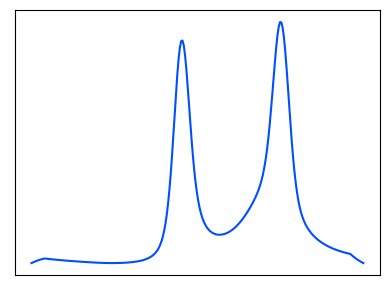

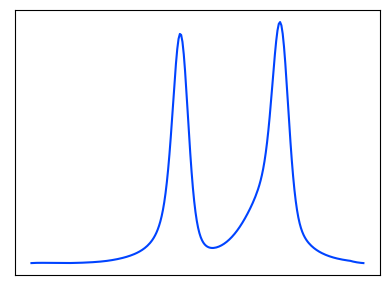

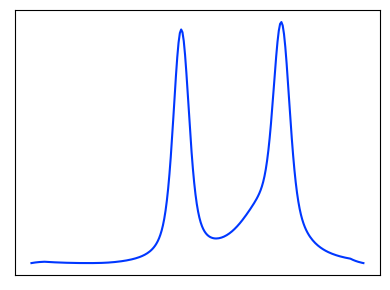

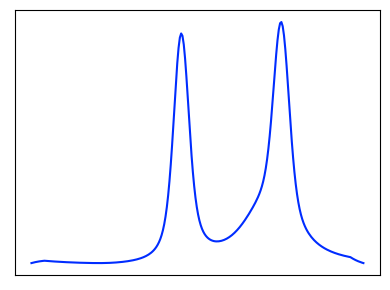

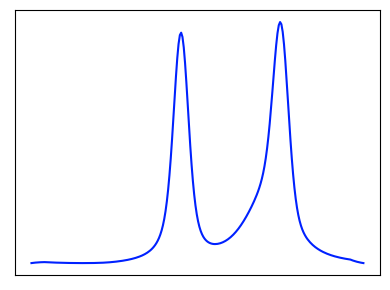

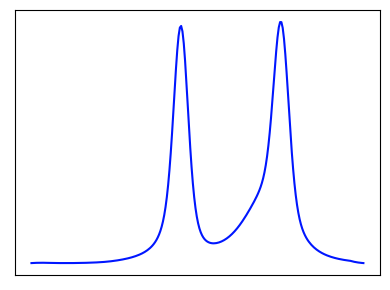

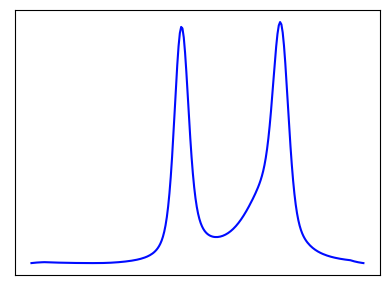

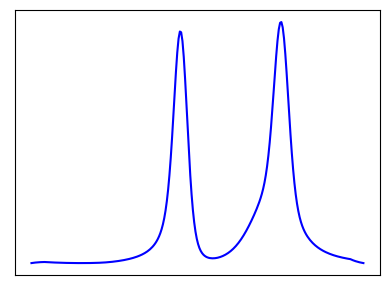

In [7]:
c0 = np.array([0., 1., 1.])
dc = np.array([0.,-1., 0.])

seed = 11

np.random.seed(seed)

brd_specs, specs, iso = dataset.__getitem__(0)



for i, spec in enumerate(brd_specs[:, 0]):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(dataset.f, brd_specs[i, 0], c=c0 + (i / (brd_specs.shape[0]-1)) * dc)
    
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    plt.close()

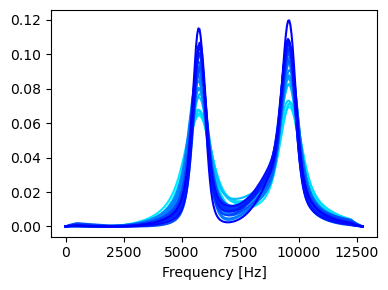

In [6]:
c0 = np.array([0., 1., 1.])
dc = np.array([0.,-1., 0.])

seed = 11

np.random.seed(seed)

brd_specs, specs, iso = dataset.__getitem__(0)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)


for i, spec in enumerate(brd_specs[:, 0]):
    ax.plot(dataset.f, brd_specs[i, 0], c=c0 + (i / (brd_specs.shape[0]-1)) * dc)

ax.set_xlabel("Frequency [Hz]")

fig.tight_layout()
plt.show()
plt.close()

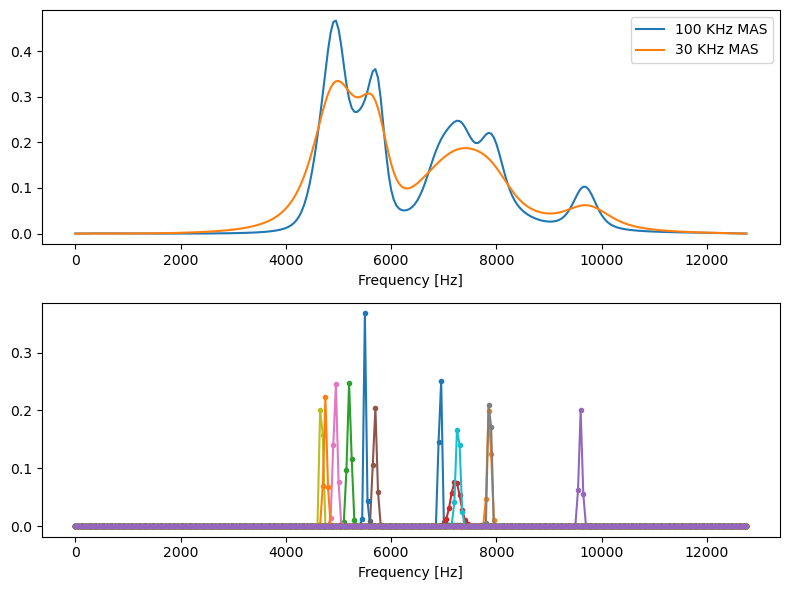

CPU times: user 1.14 s, sys: 149 ms, total: 1.29 s
Wall time: 1.33 s


In [9]:
%%time

brd_specs, specs, iso = dataset.__getitem__(0)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(dataset.f, brd_specs[-1, 0])
ax1.plot(dataset.f, brd_specs[0, 0])
for spec in specs:
    ax2.plot(dataset.f, spec, ".-")

ax1.set_xlabel("Frequency [Hz]")
ax1.legend([f"{dataset.mas_w_range[1] // 1000} KHz MAS", f"{dataset.mas_w_range[0] // 1000} KHz MAS"])
ax2.set_xlabel("Frequency [Hz]")

fig.tight_layout()
plt.show()
plt.close()

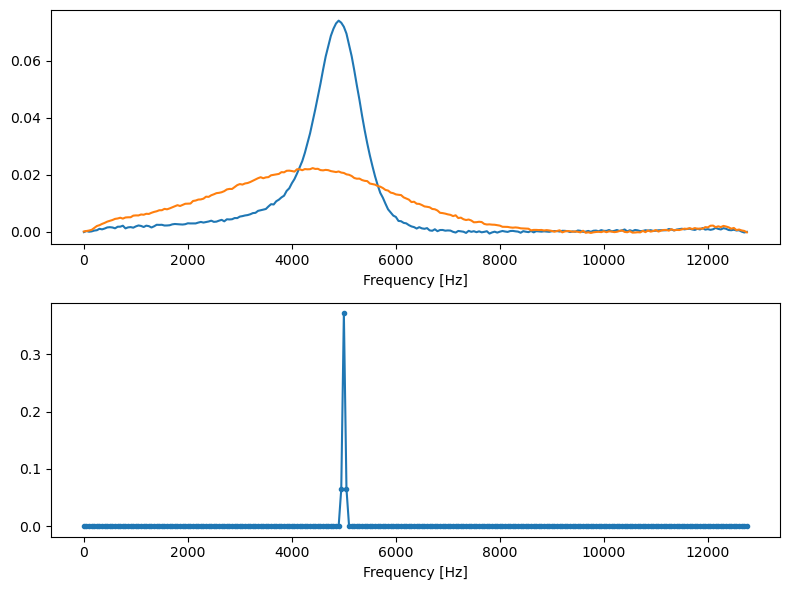

CPU times: user 188 ms, sys: 5.6 ms, total: 194 ms
Wall time: 193 ms


In [561]:
%%time

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(dataset.f, brd_specs[-1, 0] + torch.randn_like(brd_specs[-1, 0]) * model_pars["noise"])
ax1.plot(dataset.f, brd_specs[0, 0] + torch.randn_like(brd_specs[0, 0]) * model_pars["noise"])
for spec in specs:
    ax2.plot(dataset.f, spec, ".-")

ax1.set_xlabel("Frequency [Hz]")
ax2.set_xlabel("Frequency [Hz]")

fig.tight_layout()
plt.show()
plt.close()

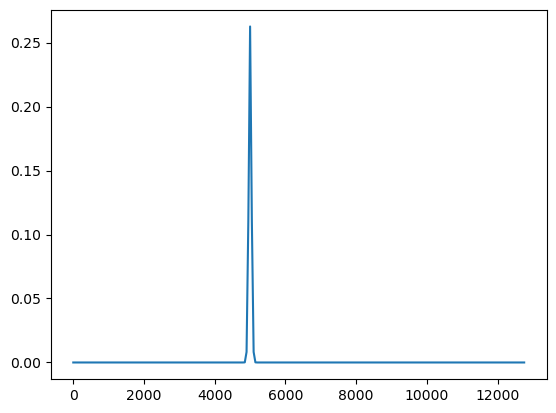

In [539]:
plt.plot(dataset.f, iso[0])
plt.show()
plt.close()